Read : Character-Level Language Model Using MLP - Part 2

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle

with open('indian_names_clean.pkl', 'rb') as f:
    names = pickle.load(f)

print(f"Ready! Loaded {len(names)} names")
print("First 10:", names[:10])

Ready! Loaded 64128 names
First 10: ['jyotirmoy', 'ilamuhil', 'indravathi', 'raamen', 'benudhar', 'mithushaya', 'malani', 'sathuna', 'oviyashri', 'vaitheeswarsn']


In [4]:
stoi = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(names)))))}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
print(f'{stoi}\n{itos}')

vocab_size = len(itos)
vocab_size

{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


28

In [5]:
# build the dataset
block_size = 3

def build_dataset(names):
    X, Y = [], []

    for name in names:
        context = [0] * block_size
        for ch in name + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtrain, Ytrain = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

torch.Size([458700, 3]) torch.Size([458700])
torch.Size([57308, 3]) torch.Size([57308])
torch.Size([57317, 3]) torch.Size([57317])


In [7]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g)
b2 = torch.randn(vocab_size,                    generator=g)

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

Total number of parameters: 12108


In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

      0/ 200000: 28.8116


Very high loss is seen during the initialization.

In [15]:
logits[10]

tensor([-10.7992,  -2.3784, -20.9161,  -6.7727,   3.2885, -18.1672,  -7.5853,
        -11.0094,  -4.3523,  -5.1222,   9.2972,   7.7634,  -3.4234,  21.4582,
        -21.1331, -10.7285, -10.8360,   0.9040, -17.1814,   5.2262,  12.6460,
         17.1117,  -1.7502, -24.9682, -21.7394, -10.3768, -34.2321, -19.9718],
       grad_fn=<SelectBackward0>)

The logits are taking up random and extreme values

### Fixing Initialization

In [16]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.1
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 4.3440


Lets make W2 even more smaller so as to bring the first loss close to the next one which was   `10000/ 200000: 2.621` as seen in `build_makemore_mlp-cleancode.ipynb`

In [20]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 3.3624


In [21]:
logits[10]

tensor([-0.0973, -0.0472, -0.1993, -0.0529,  0.0369, -0.1821, -0.0701, -0.1027,
        -0.0427, -0.0709,  0.0925,  0.0631, -0.0406,  0.2245, -0.1944, -0.1125,
        -0.1020,  0.0021, -0.1731,  0.0509,  0.1179,  0.1662, -0.0324, -0.2279,
        -0.2138, -0.1022, -0.3451, -0.2017], grad_fn=<SelectBackward0>)

We can notice that all the logits are closer to each other and not extremely scattered. Also the loss has come down a lot.

Lets run the complete optimization now

In [22]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 3.3624
  10000/ 200000: 2.3753
  20000/ 200000: 1.9067
  30000/ 200000: 2.1145
  40000/ 200000: 1.6891
  50000/ 200000: 2.1923
  60000/ 200000: 1.9254
  70000/ 200000: 2.2078
  80000/ 200000: 2.2478
  90000/ 200000: 2.0076
 100000/ 200000: 2.2549
 110000/ 200000: 1.7886
 120000/ 200000: 2.2353
 130000/ 200000: 1.9437
 140000/ 200000: 2.0150
 150000/ 200000: 1.9569
 160000/ 200000: 2.0709
 170000/ 200000: 2.3707
 180000/ 200000: 1.6450
 190000/ 200000: 1.9591


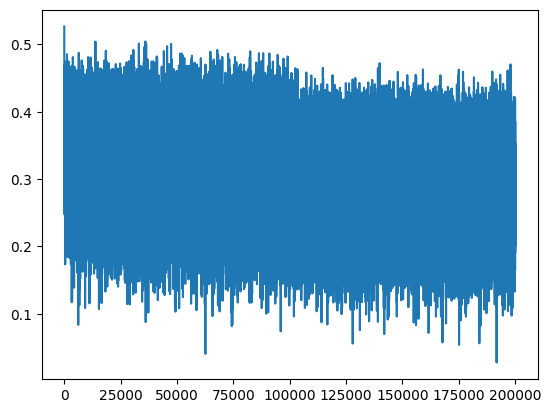

In [23]:
plt.plot(lossi)

The above plot does not look like the hockey stick pattern anymore, as our initialization process has taken down the loss from very high 28 to a megre ~4. Now the optimization process has to work hard to generate the logits and keep the losses low and there are no easy gains in the begining.

**2 good things that happened**
* The initialization loss is low and overall improved loss as compare to the previous losses (see the results in the below cell)
* The plot does not look like a hockey stick

In [24]:
@torch.no_grad()            # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]      # N x block_size x n_embd
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 +b1)         # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9706300497055054
val 1.9925583600997925


Low validation loss as compared to previous loss as seen in `build_makemore_mlp-cleancode.ipynb`

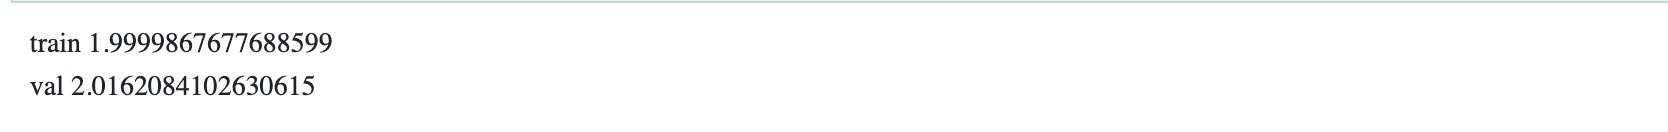

### Addressing the second problem
Refer to the section **Problem #2** in the blog Character-Level Language Model Using MLP - Part 2

In [25]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 3.3624


We have fixed the logits values by manipulating the parameters 'b' and 'W2'

Now, lets look at the values of 'h'

In [26]:
h

tensor([[ 0.9997, -1.0000, -0.9989,  ..., -0.9186,  1.0000,  0.9987],
        [-0.9279,  0.1116, -1.0000,  ..., -1.0000,  1.0000,  1.0000],
        [ 0.9975, -1.0000,  0.9830,  ...,  0.5257, -0.9985,  0.8836],
        ...,
        [ 0.9771, -0.9938, -0.9993,  ..., -0.9652,  0.9990, -0.9992],
        [-0.4157, -0.9850, -0.9715,  ..., -1.0000,  0.7628,  0.3697],
        [-0.9580,  1.0000, -0.9927,  ..., -1.0000, -0.7237, -0.9180]],
       grad_fn=<TanhBackward0>)

We can see a lot of values are close to +1 and -1.

Lets see how the values within the tensor h are distributed

In [27]:
h.shape

torch.Size([32, 200])

h has 32 rows and each row with 200 columns, lets unwrap h into 1 dimension so that we visualize each value

In [28]:
h.view(-1).shape

torch.Size([6400])

We can see how the various values of h are distributed by the help of a histogram

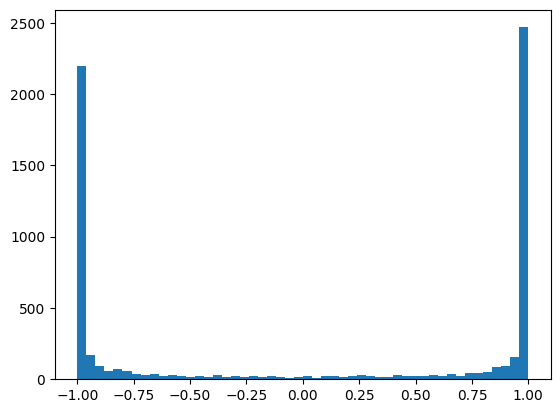

In [30]:
plt.hist(h.view(-1).tolist(), 50);

This also confirms that most of the weights within h are taking the values of -1 and +1. This means that a lot of values in `hpreact` might be taking extreme values 

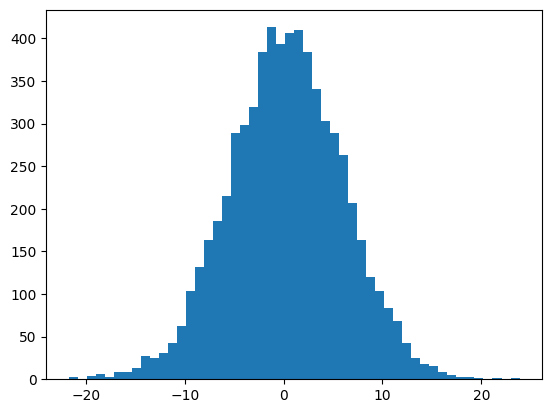

In [31]:
plt.hist(hpreact.view(-1).tolist(), 50);

The values in `hpreact` takes values from -20 to +20 and when we apply tanh to these values, they get squashed up in between -1 and +1.

Let's see how many values of tanh are in the extremes (where tanh takes the value of 0.99 or more)

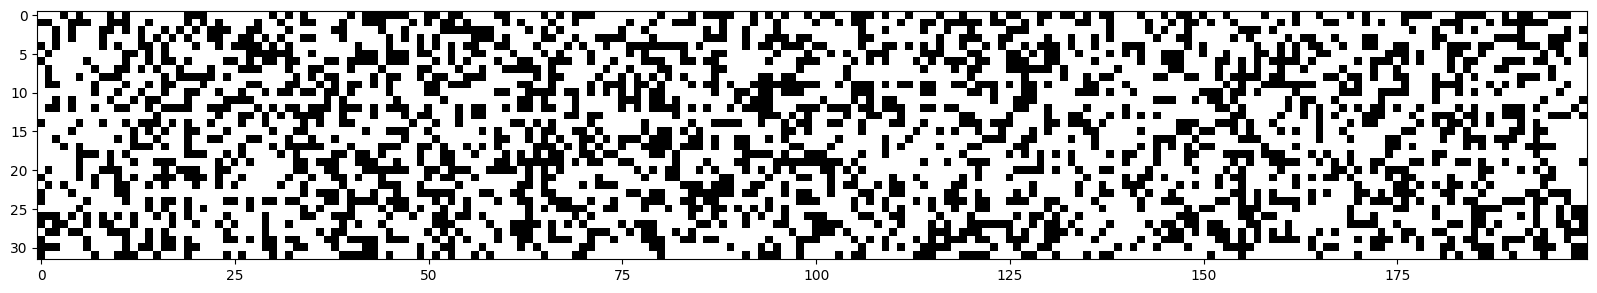

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

The above plot shows the following:
* Rows are the rows of the batch that we are passing through the trainig
* Columns are the individual neurons which are part of this activation layer
* cmap='gray':\
    White pixels → True (saturated, |h| > 0.99)\
    Black pixels → False (not saturated)

A white column means that particular hidden neuron is saturated for most examples → bad (that neuron is "dead" or barely learning). Because if the entire column is white, it means of all the batch inputs, no single example was able to pass its gradients through that neuron. no matter what the input is the neuron was always had a value of 1 or -1.

In our example, we dont have any such column, where the entire column is white. It means that for some inputs in our batch, each neuron had a chance to learn through the gradients.

The same issue arises with the below activation functions as well:
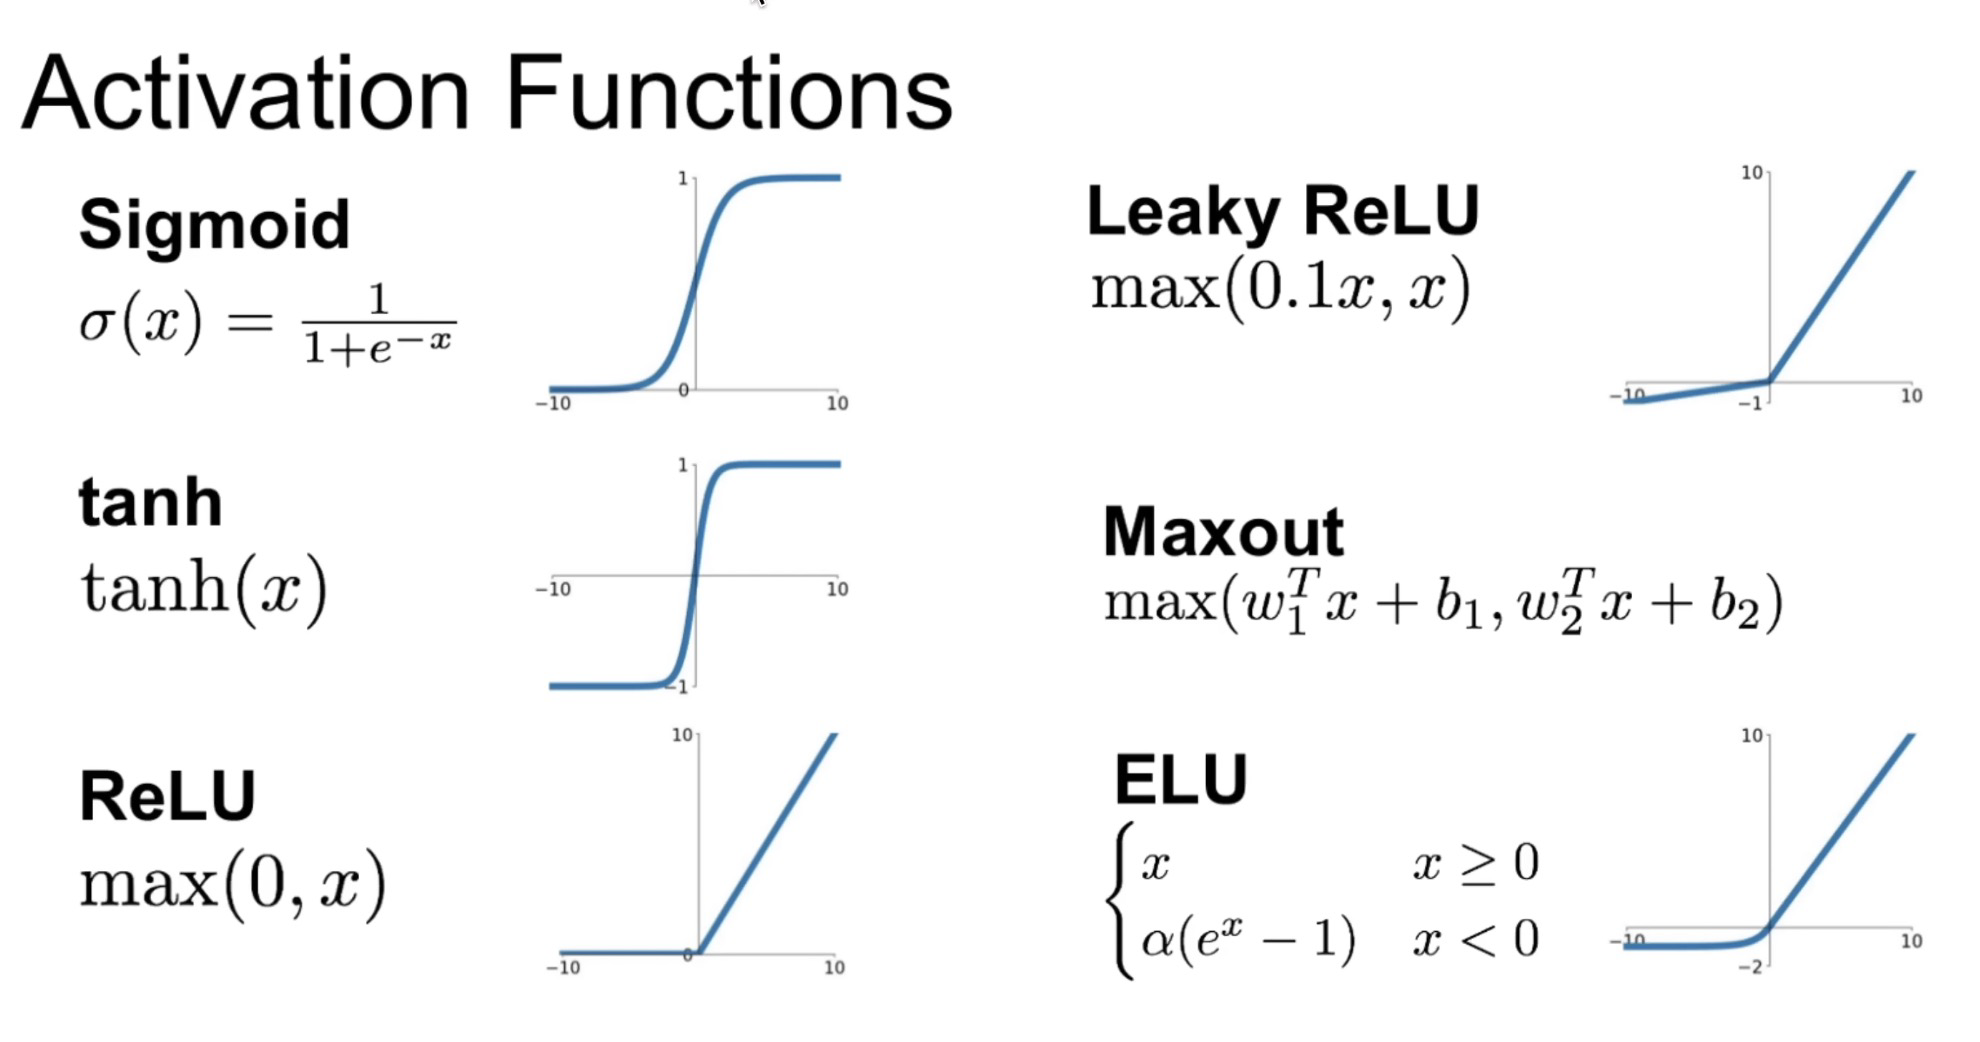

Situations, where the network might end up in a dead neuron state: Permanent dead neuron
* During initialization, if the hpreact has a lot of values which are close to -1 and +1
* During the process of optimization, if we have a large learning rate, then the gradients might for the weight values to be knocked out of the range (becomes close to +1 or -1 ) and then the activation function does not learn ever.

We need to avoid the above 2 situations.

Check the section: Fixing the Vanishing Gradient Problem in the blog Character-Level Language Model Using MLP - Part 2 to understand why we are only manipulating the values of 'W1' and 'b1' in the below cell to adjust the 'hpreact' values.

In [34]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 3.3480


Now, lets check the values of h

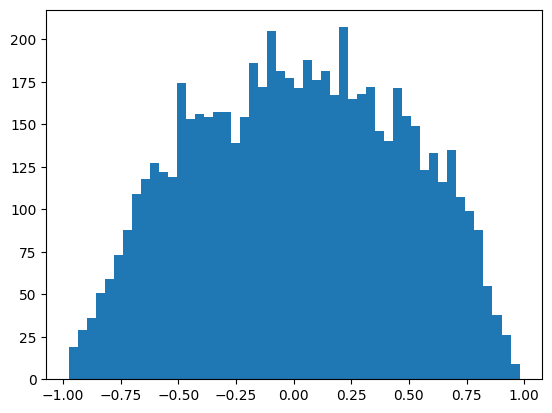

In [35]:
plt.hist(h.view(-1).tolist(), 50);

We have much better distribution of the tanh result. That is because of the much better distribution of the hpreact

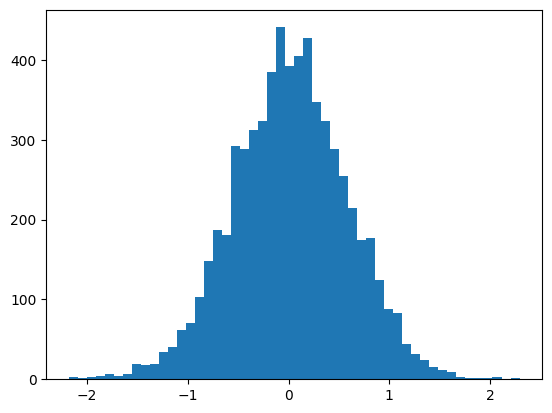

In [36]:
plt.hist(hpreact.view(-1).tolist(), 50);

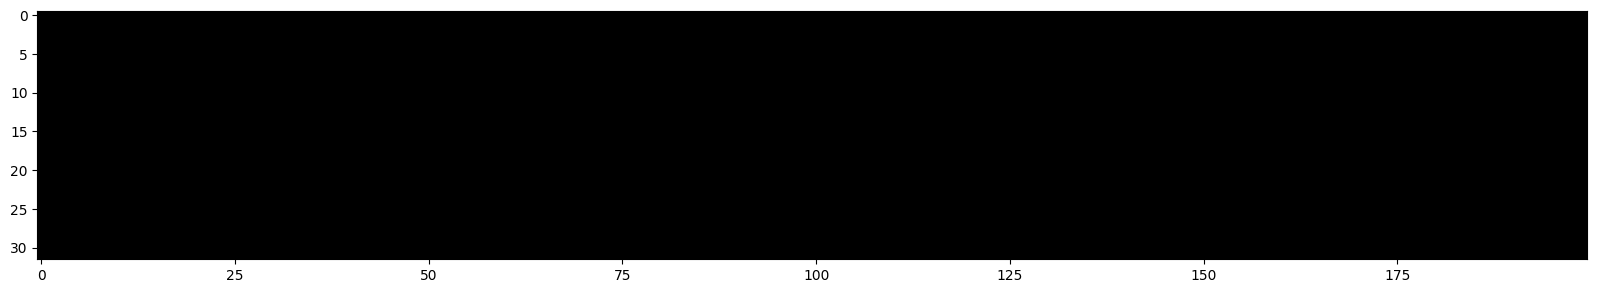

In [37]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Wow!!!

There is no white at all now. Which means no neuron saturated beyond 0.99 

In [42]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.18
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 3.3531


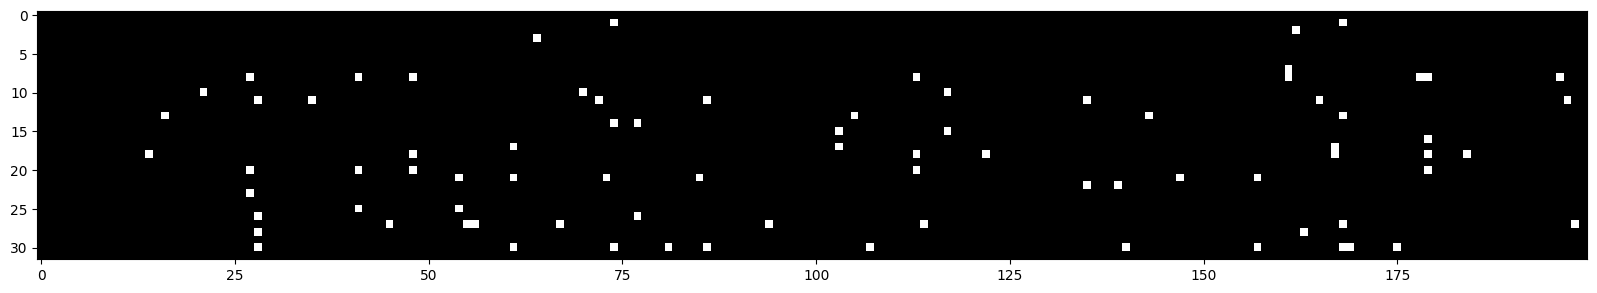

In [43]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Lets keep the above initialization setup and run the full optimization of the neural network

In [44]:
# MLP  
n_embd = 10     # dimensionality of the character embedding vectors (feature vector)
n_hidden = 200  # number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.18
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

for p in parameters:
    p.requires_grad = True

# Optimizations
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch constructs
    indices = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)

    # forward pass
    Xb = Xtrain[indices]                    # batch X
    emb = C[Xb]                             # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    Yb = Ytrain[indices]                    # batch Y
    loss = F.cross_entropy(logits, Yb)      # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01        # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                             # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())                # log compresses the loss -> better visualization

Total number of parameters: 12108
      0/ 200000: 3.3531
  10000/ 200000: 2.2216
  20000/ 200000: 1.9045
  30000/ 200000: 1.9635
  40000/ 200000: 1.7701
  50000/ 200000: 2.2393
  60000/ 200000: 1.8701
  70000/ 200000: 2.0449
  80000/ 200000: 2.1860
  90000/ 200000: 1.9812
 100000/ 200000: 2.1081
 110000/ 200000: 1.7846
 120000/ 200000: 2.2239
 130000/ 200000: 1.8899
 140000/ 200000: 1.9921
 150000/ 200000: 1.9850
 160000/ 200000: 2.1715
 170000/ 200000: 2.4043
 180000/ 200000: 1.6457
 190000/ 200000: 1.9591


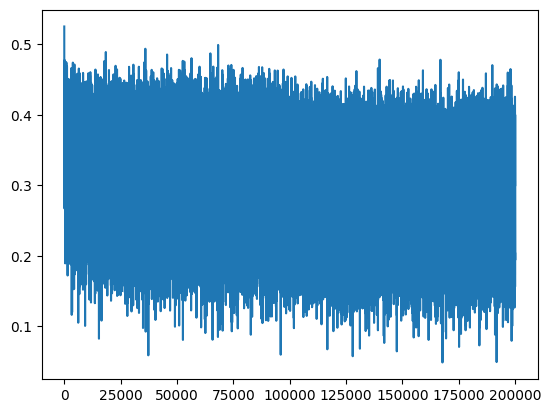

In [46]:
plt.plot(lossi);

In [47]:
@torch.no_grad()            # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]      # N x block_size x n_embd
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 +b1)         # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9548672437667847
val 1.9733407497406006


### Logging various losses at different stages

**original**
* train 1.9999867677688599
* val 2.0162084102630615

**fix softmax confidently**
* train 1.9706300497055054
* val 1.9925583600997925

**fix tanh layer too saturated at init (producing outputs very close to +1 or -1)**
* train 1.9548672437667847
* val 1.9733407497406006

In [ ]:
X = []
W3 = 1
b3 = 1
some_combined_bias = 0

In [ ]:
output = X @ (W1 @ W2 @ W3) + some_combined_bias